In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import seaborn as sns

Using TensorFlow backend.


In [230]:
BASE_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/features/')
#TRAIN_FEATURE_PATH = BASE_PATH.joinpath('InceptionResNetv2_train_10_12_19_5x_features.csv')
TRAIN_FEATURE_PATH = BASE_PATH.joinpath('InceptionResNetv2_1910_T_norm_features.csv')
VAL_FEATURE_PATH = BASE_PATH.joinpath('InceptionResNetv2_1794_T_norm_features.csv')

In [231]:
train_features = pd.read_csv(TRAIN_FEATURE_PATH)
print(train_features.shape)
val_features = pd.read_csv(VAL_FEATURE_PATH)
print(val_features.shape)

(593, 1538)
(1812, 1538)


In [232]:
train_features.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,label
0,0,1.553546,1.704086,0.618356,249.89230,15.835061,11.433720,307.02374,0.0,129.11660,...,211.99763,66.261665,5.775931,217.79176,212.19113,118.44078,31.745798,95.88461,76.833140,cancer
1,1,0.058853,0.809275,0.369929,240.55118,13.285002,10.025866,297.45868,0.0,126.92578,...,205.26660,60.543324,6.970528,209.61230,207.69359,116.93911,32.599995,100.19190,72.531654,cancer
2,2,0.356443,1.017775,0.049190,255.68560,15.515215,11.008542,320.87613,0.0,136.27008,...,220.11970,68.115870,9.281830,223.39842,228.45358,124.11187,38.565063,114.76688,80.251380,cancer
3,3,0.013678,1.232089,0.437661,252.27180,12.826366,9.614866,310.24966,0.0,132.20813,...,212.58154,64.231064,6.763873,219.09048,217.81820,121.29285,33.938810,102.46792,78.747410,cancer
4,4,0.345144,1.026844,0.352816,256.61078,15.442823,11.819534,317.57172,0.0,135.98961,...,217.37117,65.930300,9.146255,223.80931,223.10663,124.16689,35.177494,107.34873,78.987170,cancer


In [233]:
val_features.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,label
0,0,0.012760,1.043580,0.443372,271.26917,14.500371,11.133030,340.60416,0.0,145.24660,...,233.86476,70.158936,8.995304,238.85594,239.35876,134.896300,38.572678,114.536050,82.68778,cancer
1,1,0.589019,1.182350,0.387137,265.72006,14.894746,10.898689,329.28064,0.0,141.84862,...,225.71393,68.297165,7.153481,231.52844,232.81621,127.951546,38.017850,113.443825,82.06187,cancer
2,2,0.029459,1.277742,0.689269,254.88945,15.347475,12.154639,324.56990,0.0,137.68794,...,224.51526,65.895430,8.599463,226.32326,231.60353,130.639400,39.318382,117.580650,77.27674,cancer
3,3,1.553150,1.755907,0.593548,246.40533,15.625987,11.827133,307.57025,0.0,129.29105,...,209.31157,64.434906,8.192343,217.11003,210.16400,120.332410,32.988895,97.396300,78.26033,cancer
4,4,0.014187,0.924962,0.338963,270.65268,16.415543,11.052420,334.88907,0.0,141.85786,...,231.55373,71.116530,8.076329,235.85103,236.37453,130.687090,38.252895,111.043440,84.09759,cancer


In [234]:
train_features = train_features.drop('Unnamed: 0', axis = 'columns')
val_features = val_features.drop('Unnamed: 0', axis = 'columns')

In [235]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,label
0,1.553546,1.704086,0.618356,249.89230,15.835061,11.433720,307.02374,0.0,129.11660,84.38166,...,211.99763,66.261665,5.775931,217.79176,212.19113,118.44078,31.745798,95.88461,76.833140,cancer
1,0.058853,0.809275,0.369929,240.55118,13.285002,10.025866,297.45868,0.0,126.92578,86.03883,...,205.26660,60.543324,6.970528,209.61230,207.69359,116.93911,32.599995,100.19190,72.531654,cancer
2,0.356443,1.017775,0.049190,255.68560,15.515215,11.008542,320.87613,0.0,136.27008,95.12726,...,220.11970,68.115870,9.281830,223.39842,228.45358,124.11187,38.565063,114.76688,80.251380,cancer
3,0.013678,1.232089,0.437661,252.27180,12.826366,9.614866,310.24966,0.0,132.20813,89.06052,...,212.58154,64.231064,6.763873,219.09048,217.81820,121.29285,33.938810,102.46792,78.747410,cancer
4,0.345144,1.026844,0.352816,256.61078,15.442823,11.819534,317.57172,0.0,135.98961,91.59225,...,217.37117,65.930300,9.146255,223.80931,223.10663,124.16689,35.177494,107.34873,78.987170,cancer


In [236]:
non_cancer_features = train_features.loc[train_features['label'] == 'non-cancer']
non_cancer_features = non_cancer_features.iloc[:1027,:]

In [237]:
cancer_features = train_features.loc[train_features['label'] == 'cancer']
cancer_features.shape

(387, 1537)

In [238]:
all_train_features = pd.concat([non_cancer_features, cancer_features], axis = 0)

In [239]:
all_train_features

,0,1,2,3,4,5,6,7,8,9,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,label
387,0.000000,1.309609,0.550339,242.23123,13.136091,9.332075,296.71740,0.0,125.057755,85.161190,...,205.145700,61.904896,6.375022,210.81885,209.72934,117.540985,34.111520,100.151680,73.830696,non-cancer
388,0.000000,0.521579,0.146275,158.80963,9.395949,7.025531,196.52435,0.0,83.815060,56.386810,...,134.899370,40.946175,5.215108,137.65955,137.81000,76.739190,22.341803,68.864680,48.574028,non-cancer
389,0.000000,1.100967,0.459528,250.71794,13.546804,10.172108,313.55722,0.0,133.558320,90.115685,...,214.053600,65.384690,7.794091,219.30130,220.57503,122.892880,35.439228,107.394165,76.944610,non-cancer
390,0.130839,0.636992,0.515741,210.00317,12.688209,9.618944,259.68910,0.0,111.326700,75.142760,...,179.265640,55.133476,6.604823,184.12460,183.66634,102.691520,29.129213,87.451720,63.352367,non-cancer
391,0.000000,0.820371,0.371932,213.13504,11.370584,7.596703,264.56638,0.0,114.455795,77.625640,...,182.660370,55.790016,5.270006,186.99074,188.41577,103.670260,30.998990,91.489330,64.713875,non-cancer
392,0.080044,1.422254,0.486234,247.43042,13.684791,10.357358,308.75354,0.0,130.530260,92.086130,...,213.105740,65.192940,7.371862,216.03131,219.38882,120.457466,35.392822,105.904880,77.314580,non-cancer
393,0.543306,1.059531,0.409210,213.22960,12.681789,10.615730,273.85724,0.0,114.971560,84.372570,...,189.940660,54.824852,9.057451,189.52301,193.14081,109.660750,32.240040,96.529020,63.771450,non-cancer
394,0.109126,0.756670,0.168940,230.64847,13.154582,11.358856,292.86163,0.0,121.687030,85.405390,...,202.777710,59.561466,7.571546,204.60023,202.55273,118.018290,31.589870,96.257890,70.386990,non-cancer
395,0.000000,0.940370,0.341707,212.14458,11.087985,9.068029,264.69543,0.0,113.509476,78.794550,...,182.960390,54.327057,7.089564,186.21475,187.55501,104.704100,30.610950,91.260370,65.449810,non-cancer
396,0.188349,0.850674,0.488402,241.77098,14.502331,9.244316,300.87396,0.0,129.336170,88.298805,...,207.644090,62.876858,6.266893,212.25899,213.41422,118.347570,34.675350,105.267350,73.474200,non-cancer


In [240]:
all_train_features = all_train_features.sample(frac=1)

In [241]:
all_train_features

,0,1,2,3,4,5,6,7,8,9,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,label
43,0.234481,1.241926,0.348455,261.55606,15.742727,10.477417,325.69910,0.000000,137.479100,95.652700,...,226.220830,68.080660,6.837533,230.06410,230.11542,130.103030,36.283722,106.027016,78.130684,cancer
159,0.262648,1.047880,0.514152,255.51852,13.805172,9.458279,315.97412,0.000000,134.618550,92.030020,...,217.001160,65.727370,6.267964,222.68747,223.69608,124.636150,35.564068,106.134090,78.658870,cancer
332,0.000000,1.384633,0.791098,239.81194,13.291643,11.094875,300.31757,0.000000,127.982820,88.639460,...,206.684540,62.825440,9.074101,211.61073,212.89253,117.947970,35.061474,101.707634,73.926506,cancer
528,0.070576,1.310644,0.545667,228.09814,13.893065,9.454817,280.06320,0.000000,118.198510,78.547806,...,195.470610,61.373707,4.644426,200.06793,196.16180,110.761240,30.016148,86.451190,69.213300,non-cancer
446,0.569096,0.855662,0.163495,154.69461,8.898127,5.851308,187.94589,0.000000,79.547350,53.430450,...,128.848750,38.818260,3.376611,133.60464,131.83496,72.798400,19.998714,59.532627,48.752020,non-cancer
276,0.677122,1.105787,0.464364,262.45697,16.213718,11.066295,327.08582,0.000000,139.039520,96.330040,...,224.069230,68.242920,8.151791,229.24380,231.48177,128.380630,37.326237,110.285484,80.995920,cancer
57,0.000000,1.222786,0.646502,275.46024,16.337091,10.301756,341.89760,0.000000,147.906370,100.990470,...,236.422230,72.350960,5.846121,241.63853,246.60564,135.071320,44.325108,123.570030,84.369670,cancer
252,0.410395,0.733722,0.459724,229.08240,12.693244,11.126514,282.42096,0.000000,120.017815,80.346950,...,194.370420,55.730843,8.016060,199.26793,195.23300,109.981285,30.126154,95.993080,70.035990,cancer
179,0.000000,1.117648,0.442937,243.60089,14.523967,10.726326,306.36180,0.000000,130.958630,91.184090,...,212.826250,63.790302,7.483837,215.76953,217.19852,121.973210,36.332040,105.069640,73.121605,cancer
22,0.000000,1.207236,0.373504,249.75772,13.751769,12.122533,315.40054,0.000000,133.024860,94.033820,...,217.219070,63.229477,9.620792,218.51534,220.52605,124.834160,35.185757,109.735176,75.883530,cancer


In [242]:
val_features.head()

,0,1,2,3,4,5,6,7,8,9,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,label
0,0.012760,1.043580,0.443372,271.26917,14.500371,11.133030,340.60416,0.0,145.24660,99.636570,...,233.86476,70.158936,8.995304,238.85594,239.35876,134.896300,38.572678,114.536050,82.68778,cancer
1,0.589019,1.182350,0.387137,265.72006,14.894746,10.898689,329.28064,0.0,141.84862,95.883750,...,225.71393,68.297165,7.153481,231.52844,232.81621,127.951546,38.017850,113.443825,82.06187,cancer
2,0.029459,1.277742,0.689269,254.88945,15.347475,12.154639,324.56990,0.0,137.68794,99.318160,...,224.51526,65.895430,8.599463,226.32326,231.60353,130.639400,39.318382,117.580650,77.27674,cancer
3,1.553150,1.755907,0.593548,246.40533,15.625987,11.827133,307.57025,0.0,129.29105,85.700714,...,209.31157,64.434906,8.192343,217.11003,210.16400,120.332410,32.988895,97.396300,78.26033,cancer
4,0.014187,0.924962,0.338963,270.65268,16.415543,11.052420,334.88907,0.0,141.85786,99.353690,...,231.55373,71.116530,8.076329,235.85103,236.37453,130.687090,38.252895,111.043440,84.09759,cancer


In [243]:
train_labels = all_train_features['label']
val_labels = val_features['label']

In [244]:
lb = LabelBinarizer()
Y_train = lb.fit_transform(train_labels)
Y_val = lb.transform(val_labels)

In [245]:
X_train = np.array(all_train_features.drop('label', axis = 'columns'))
X_val = np.array(val_features.drop('label', axis = 'columns'))

In [246]:
#X_train = np.transpose(X_train)
#X_val = np.transpose(X_val)

In [247]:
scaler = StandardScaler().fit(X_train)
#scaler = MinMaxScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
print(X_train_norm.shape)

(593, 1536)


In [248]:
X_val_norm = scaler.transform(X_val)
#X_val_norm = StandardScaler().fit_transform(X_val)

In [249]:
X_val_norm.shape

(1812, 1536)

In [250]:
#X_train_norm = np.transpose(X_train_norm)
#X_val_norm = np.transpose(X_val_norm)

0.9577553046993935
0.4601957229726099


(array([  4.,   7.,   4.,  15.,  21.,  32.,  46.,  49.,  78.,  89., 131.,
        121., 166., 198., 207., 262., 208., 122.,  41.,  11.]),
 array([-3.05696905, -2.78748485, -2.51800065, -2.24851645, -1.97903225,
        -1.70954805, -1.44006386, -1.17057966, -0.90109546, -0.63161126,
        -0.36212706, -0.09264286,  0.17684133,  0.44632553,  0.71580973,
         0.98529393,  1.25477813,  1.52426233,  1.79374652,  2.06323072,
         2.33271492]),
 <a list of 20 Patch objects>)

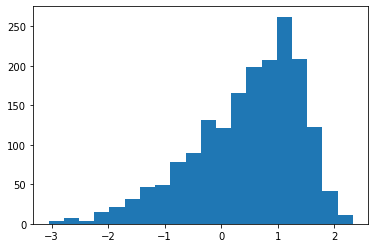

In [251]:
VAL_NUM = 8
print(X_val_norm[:,VAL_NUM].std())
print(X_val_norm[:,VAL_NUM].mean())
plt.hist(X_val_norm[:,VAL_NUM], bins = 20)

In [252]:
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state = 42)

In [253]:
#random_array = np.round(np.random.rand(8)).astype(np.uint8)

In [270]:
model = Sequential()
model.add(Dense(1536, input_shape=(1536,), activation = 'relu'))
#model.add(Dense(2048, input_shape=(2048,), activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(1024, activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(1024, activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'RMSprop', metrics=['accuracy'] )

In [271]:
H = model.fit(X_train_norm, Y_train, validation_data=(X_val_norm, Y_val), epochs = 100, batch_size = 700)

Train on 593 samples, validate on 1812 samples
Epoch 1/100
593/593 [==============================] - 1s 1ms/step - loss: 0.7018 - acc: 0.6239 - val_loss: 3.0082 - val_acc: 0.7627
Epoch 2/100
593/593 [==============================] - 0s 137us/step - loss: 1.6994 - acc: 0.7808 - val_loss: 6.5695 - val_acc: 0.5668
Epoch 3/100
593/593 [==============================] - 0s 139us/step - loss: 5.2817 - acc: 0.6526 - val_loss: 12.5997 - val_acc: 0.2036
Epoch 4/100
593/593 [==============================] - 0s 145us/step - loss: 11.5101 - acc: 0.2496 - val_loss: 8.3786 - val_acc: 0.2147
Epoch 5/100
593/593 [==============================] - 0s 138us/step - loss: 6.5900 - acc: 0.3238 - val_loss: 6.7571 - val_acc: 0.5668
Epoch 6/100
593/593 [==============================] - 0s 134us/step - loss: 5.3620 - acc: 0.6526 - val_loss: 6.4676 - val_acc: 0.5668
Epoch 7/100
593/593 [==============================] - 0s 137us/step - loss: 5.1449 - acc: 0.6526 - val_loss: 6.0198 - val_acc: 0.5668
Epoch 8/

Epoch 61/100
593/593 [==============================] - 0s 132us/step - loss: 0.3832 - acc: 0.8533 - val_loss: 1.2341 - val_acc: 0.5894
Epoch 62/100
593/593 [==============================] - 0s 136us/step - loss: 0.6685 - acc: 0.7234 - val_loss: 0.6611 - val_acc: 0.7991
Epoch 63/100
593/593 [==============================] - 0s 136us/step - loss: 1.0626 - acc: 0.8246 - val_loss: 1.4512 - val_acc: 0.7677
Epoch 64/100
593/593 [==============================] - 0s 135us/step - loss: 0.4558 - acc: 0.8415 - val_loss: 0.8069 - val_acc: 0.6749
Epoch 65/100
593/593 [==============================] - 0s 145us/step - loss: 0.3507 - acc: 0.7943 - val_loss: 0.9362 - val_acc: 0.7947
Epoch 66/100
593/593 [==============================] - 0s 133us/step - loss: 0.5907 - acc: 0.8465 - val_loss: 0.5696 - val_acc: 0.8240
Epoch 67/100
593/593 [==============================] - 0s 135us/step - loss: 0.3463 - acc: 0.8600 - val_loss: 1.5876 - val_acc: 0.7627
Epoch 68/100
593/593 [==========================

In [272]:
val_loss, val_acc = model.evaluate(X_val_norm, Y_val)
print('Loss: {0} Acc: {1}'.format(val_loss, val_acc))

1812/1812 [==============================] - 0s 86us/step
Loss: 0.8489298109976661 Acc: 0.788079470330253


In [257]:
np.unique(Y_train, return_counts = True)

(array([0, 1]), array([387, 206]))

(array([275.,  28.,  26.,  19.,   9.,  19.,  31.,  36.,  27., 123.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

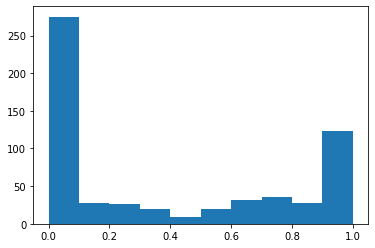

In [273]:
train_sigmoid = model.predict(X_train_norm)
plt.hist(train_sigmoid)

In [259]:
lb.transform(['cancer'])

array([[0]])

In [279]:
np.unique(Y_val, return_counts = True)

(array([0, 1]), array([1027,  785]))

In [275]:
val_sigmoid = model.predict(X_val_norm)

(array([697., 242., 144., 108., 104.,  86.,  72.,  69.,  80., 210.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

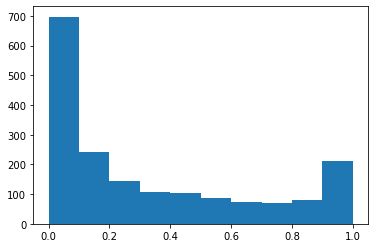

In [276]:
plt.hist(val_sigmoid)

In [263]:
np.sum(val_sigmoid > 0.5)

338

In [264]:
def plot_confusion_matrix(cm, classes=None):
    #Normalise Confusion Matrix by dividing each value by the sum of that row
    cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
    print(cm)
    #Make DataFrame from Confusion Matrix and classes
    cm_df = pd.DataFrame(cm, index = classes, columns = classes)
    #Display Confusion Matrix 
    plt.figure(figsize = (4,4), dpi = 300)
    cm_plot = sns.heatmap(cm_df, vmin = 0, vmax = 1, annot = True, fmt = '.2f', cmap = 'Blues', square = True)
    plt.title('Confusion Matrix', fontsize = 12)
    #Display axes labels
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.savefig('./age_confusion_matrix_combine.pdf')
    plt.tight_layout()
    return cm_plot

In [265]:
Y_val[::-1]

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [266]:
np.invert(Y_val.astype(np.bool)).astype(np.int64)

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [267]:
val_sigmoid > 0.5

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [277]:
cm = confusion_matrix(Y_val, (val_sigmoid > 0.5).astype(np.int64))
cm

array([[969,  58],
       [326, 459]])

[[0.94352483 0.05647517]
 [0.41528662 0.58471338]]


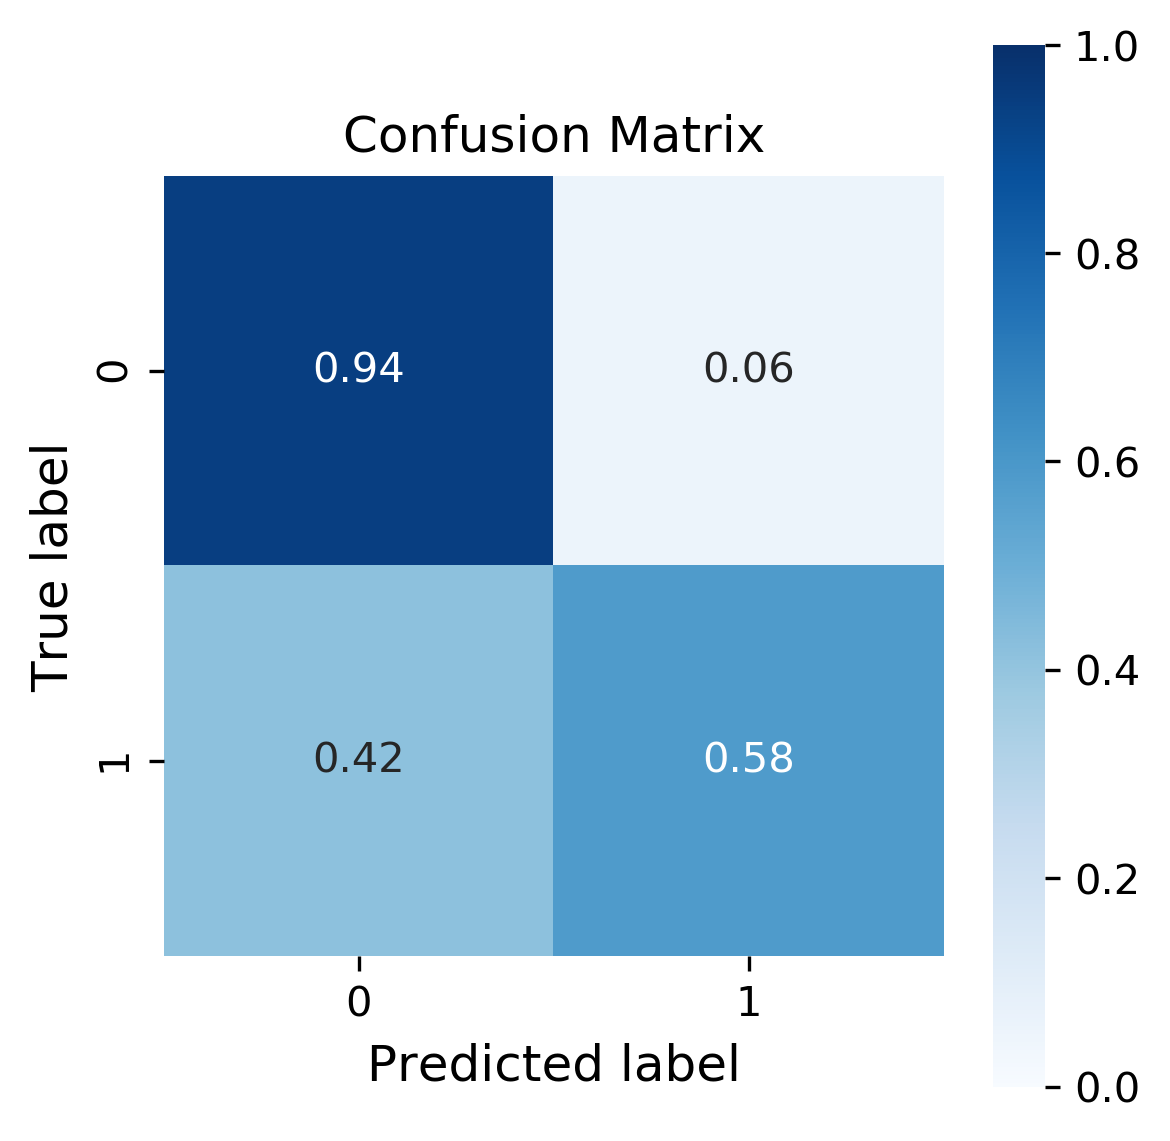

In [278]:
plot_confusion_matrix(cm)